In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('/usr/bmicnas02/data-biwi-01/jeremy_students/lschlyter/4dflowmri_anomaly_detection')
from config import system_eval as config_sys
project_code_root = config_sys.project_code_root
suffix = ''
geometry_path = os.path.join(project_code_root, f'data/geometry_for_backtransformation{suffix}')


In [2]:

def is_rotation_matrix(matrix):
    if matrix.shape[0] != matrix.shape[1]:
        return False
    identity_approx = np.dot(matrix, matrix.T)
    if not np.allclose(identity_approx, np.eye(matrix.shape[0]), atol=1e-6):
        return False
    if not np.isclose(np.linalg.det(matrix), 1.0, atol=1e-6):
        return False
    return True

def matrix_to_euler_angles(matrix):
    sy = np.sqrt(matrix[0,0] * matrix[0,0] + matrix[1,0] * matrix[1,0])
    singular = sy < 1e-6
    if not singular:
        x = np.arctan2(matrix[2,1], matrix[2,2])
        y = np.arctan2(-matrix[2,0], sy)
        z = np.arctan2(matrix[1,0], matrix[0,0])
    else:
        x = np.arctan2(-matrix[1,2], matrix[1,1])
        y = np.arctan2(-matrix[2,0], sy)
        z = 0
    return np.array([x, y, z])

def decompose_matrix(matrix):
    U, Sigma, Vt = np.linalg.svd(matrix)
    rotation_matrix = np.dot(U, Vt)
    return rotation_matrix, Sigma


In [3]:
# Initialize dictionaries to hold the Euler angles and traces for each subject
subjects_euler_angles = {}
subjects_traces = {}

for subject_id in os.listdir(geometry_path):
    geometry_dict = np.load(os.path.join(geometry_path, subject_id), allow_pickle=True).item()
    
    # Initialize lists to hold the Euler angles and traces for each slice of the current subject
    subject_euler_angles = []
    subject_traces = []
    
    # Go through each slice
    for slice_i in range(64):
        matrix = geometry_dict[f"slice_{slice_i}"]["transform"].GetMatrix()
        matrix = np.array(matrix).reshape(3,3)

        if is_rotation_matrix(matrix):
            euler_angles = matrix_to_euler_angles(matrix)
            trace = np.trace(matrix)
        else:
            rotation_matrix, scaling_factors = decompose_matrix(matrix)
            if is_rotation_matrix(rotation_matrix):
                euler_angles = matrix_to_euler_angles(rotation_matrix)
                trace = np.trace(rotation_matrix)
            else:
                print("Failed to extract a valid rotation matrix for subject", subject_id, "slice", slice_i)
                euler_angles = None  # You could use np.nan or a specific placeholder value here
                trace = None
        
        # Save the Euler angles and trace for this slice
        subject_euler_angles.append(euler_angles)
        subject_traces.append(trace)
    
    # Save the Euler angles and traces for all slices of the current subject
    subjects_euler_angles[subject_id] = subject_euler_angles
    subjects_traces[subject_id] = subject_traces

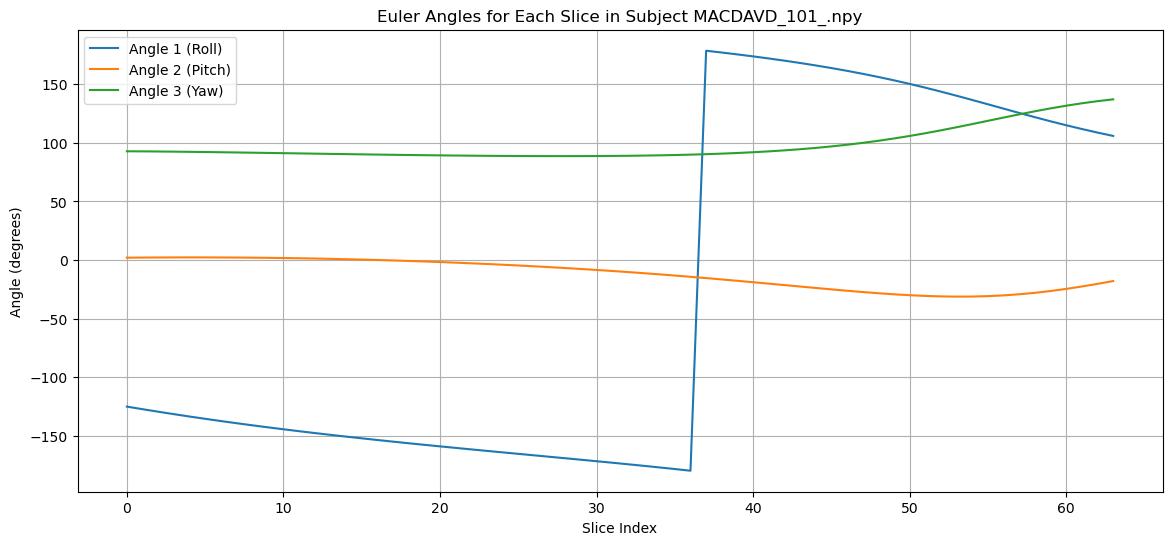

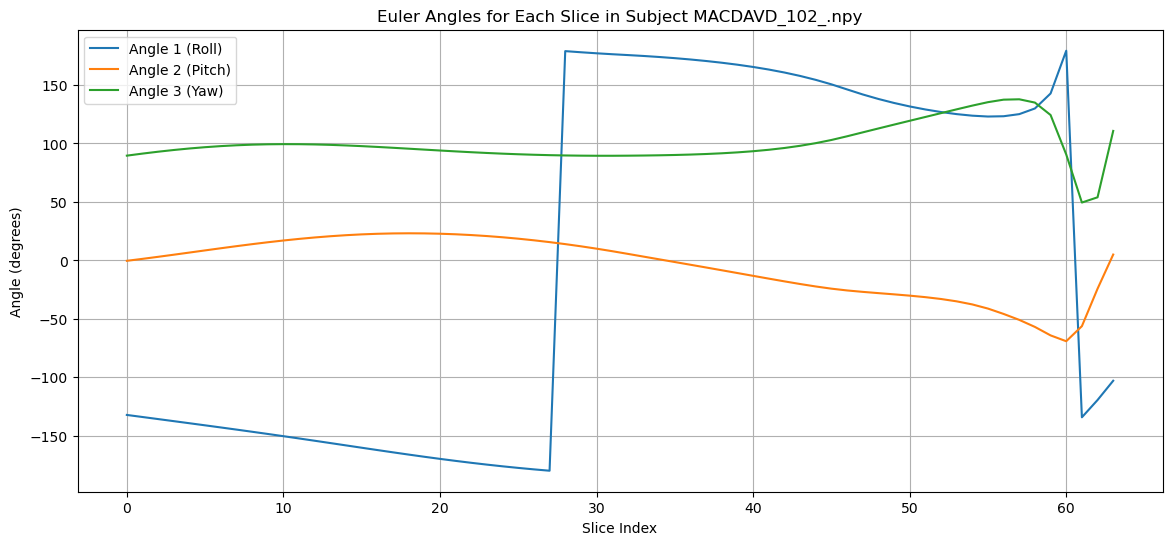

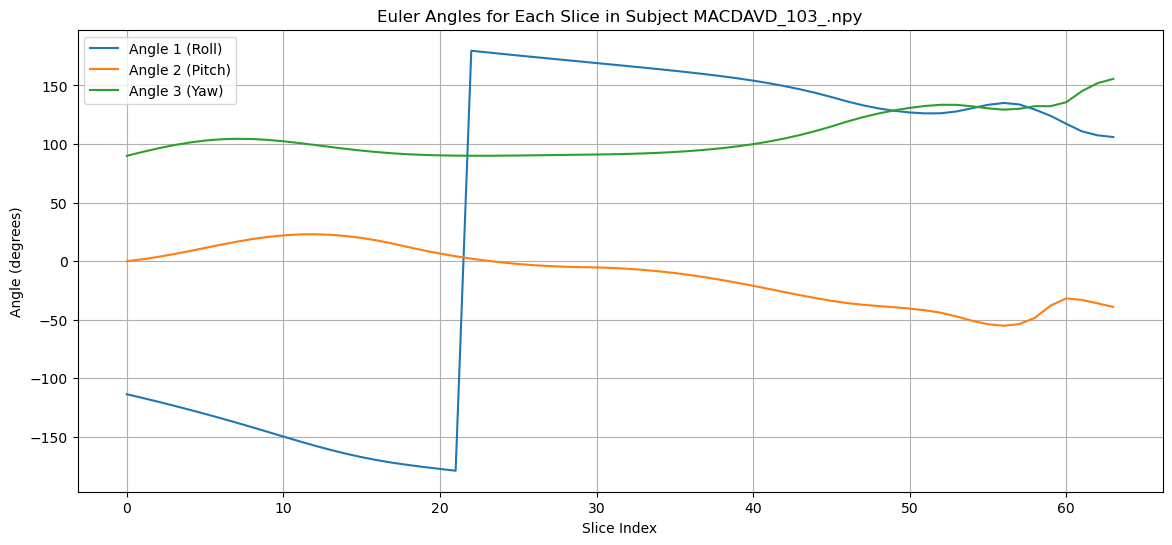

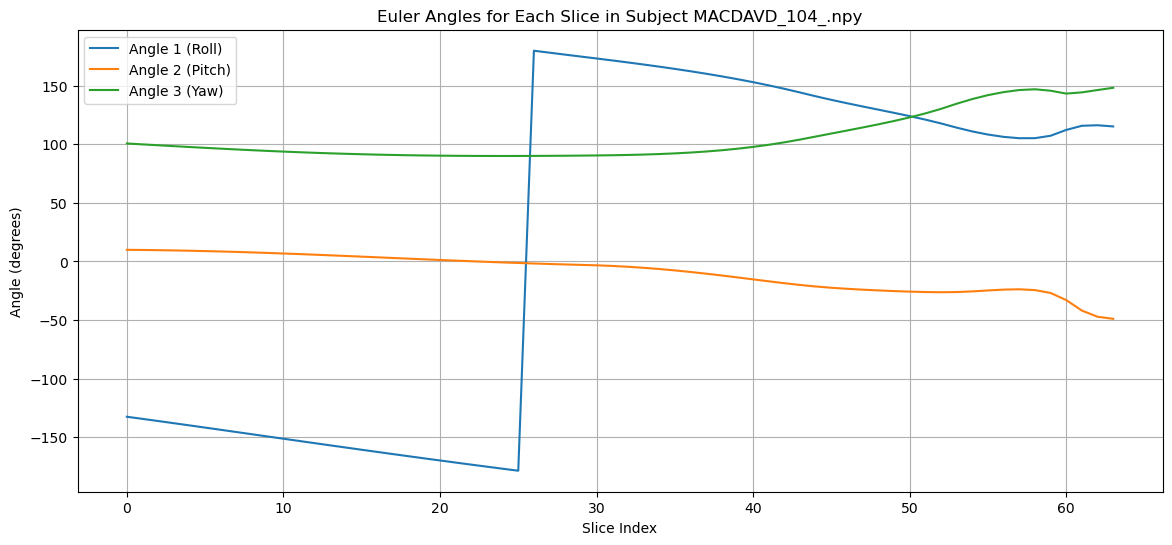

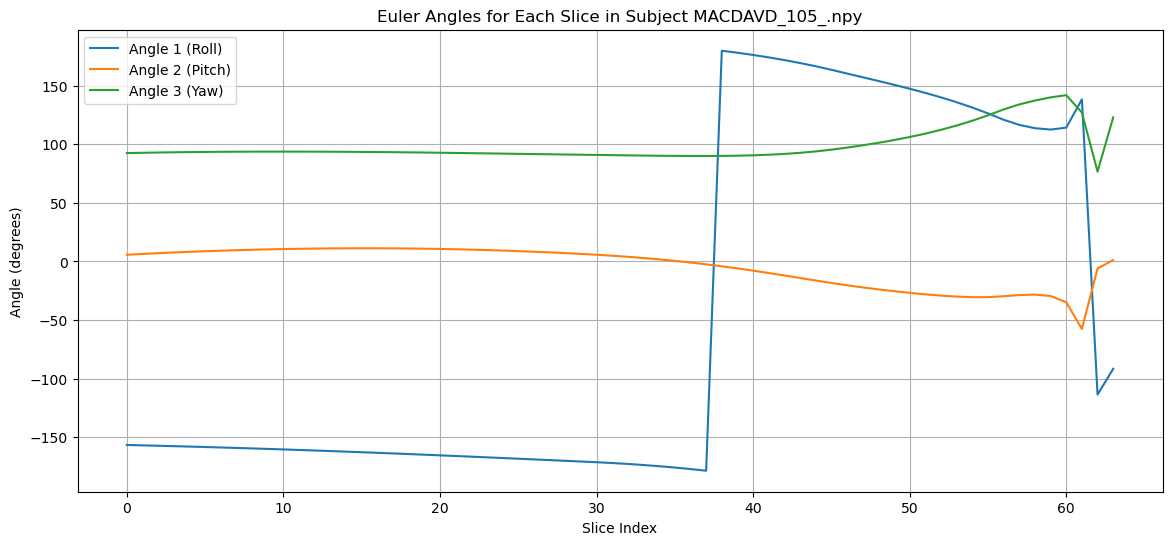

In [4]:
number_subjects_to_plot = 5

for n in range(len(os.listdir(geometry_path)[:number_subjects_to_plot])):
    subject_id = list(subjects_euler_angles.keys())[n]
    euler_angles = np.array(subjects_euler_angles[subject_id])  

    # Convert radians to degrees
    euler_angles_degrees = np.degrees(euler_angles)

    # Plotting
    plt.figure(figsize=(14, 6))
    plt.plot(euler_angles_degrees[:, 0], label='Angle 1 (Roll)')
    plt.plot(euler_angles_degrees[:, 1], label='Angle 2 (Pitch)')
    plt.plot(euler_angles_degrees[:, 2], label='Angle 3 (Yaw)')
    plt.xlabel('Slice Index')
    plt.ylabel('Angle (degrees)')
    plt.title(f'Euler Angles for Each Slice in Subject {subject_id}')
    plt.legend()
    plt.grid(True)
    plt.show()

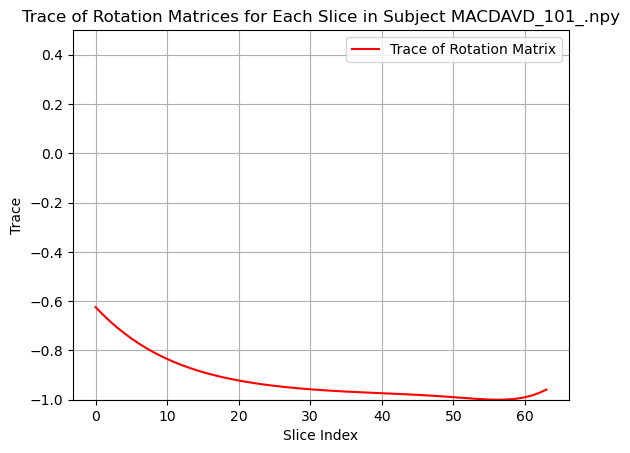

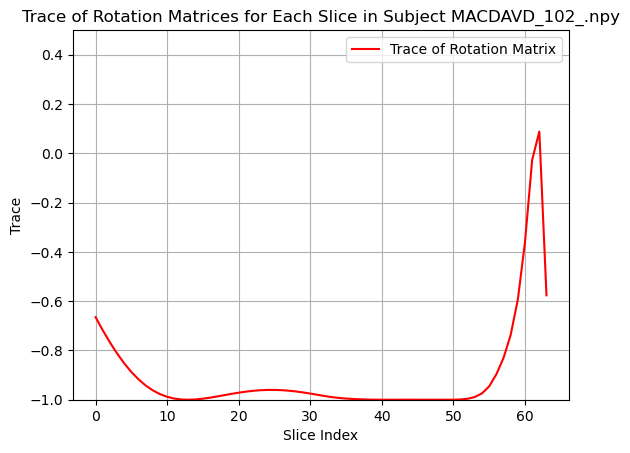

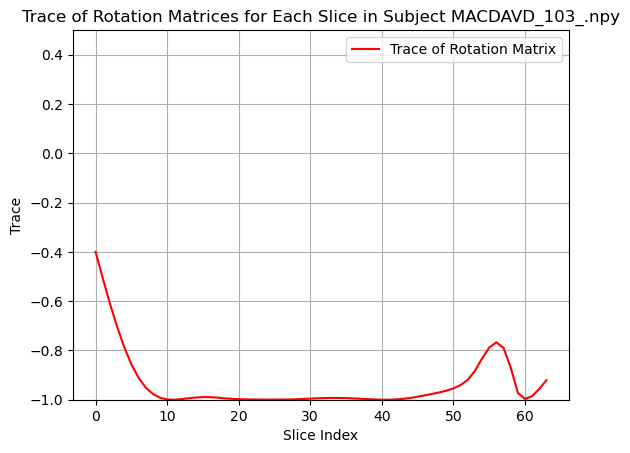

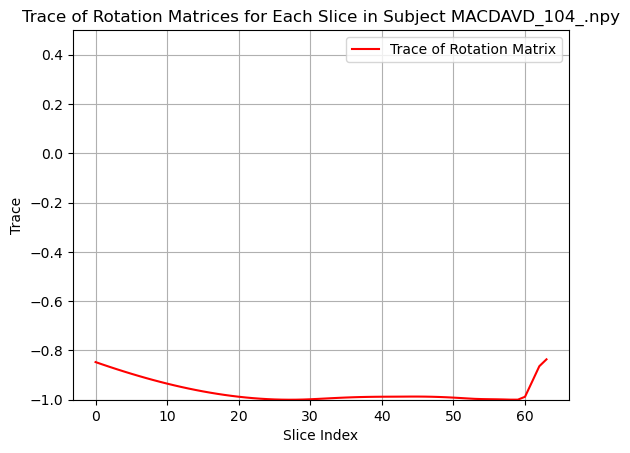

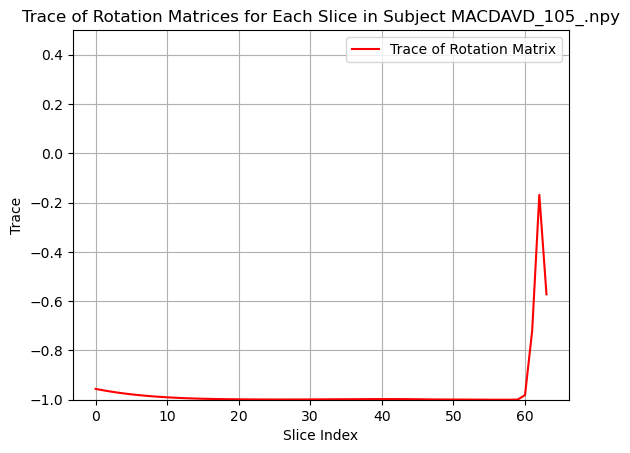

In [5]:
for n in range(len(os.listdir(geometry_path)[:number_subjects_to_plot])):
    subject_id = list(subjects_euler_angles.keys())[n]
    traces = subjects_traces[subject_id]

    plt.plot(traces, label='Trace of Rotation Matrix', color='red')
    plt.xlabel('Slice Index')
    plt.ylabel('Trace')
    plt.title(f'Trace of Rotation Matrices for Each Slice in Subject {subject_id}')
    plt.legend()
    plt.ylim(-1, .5)
    plt.grid(True)
    plt.show()

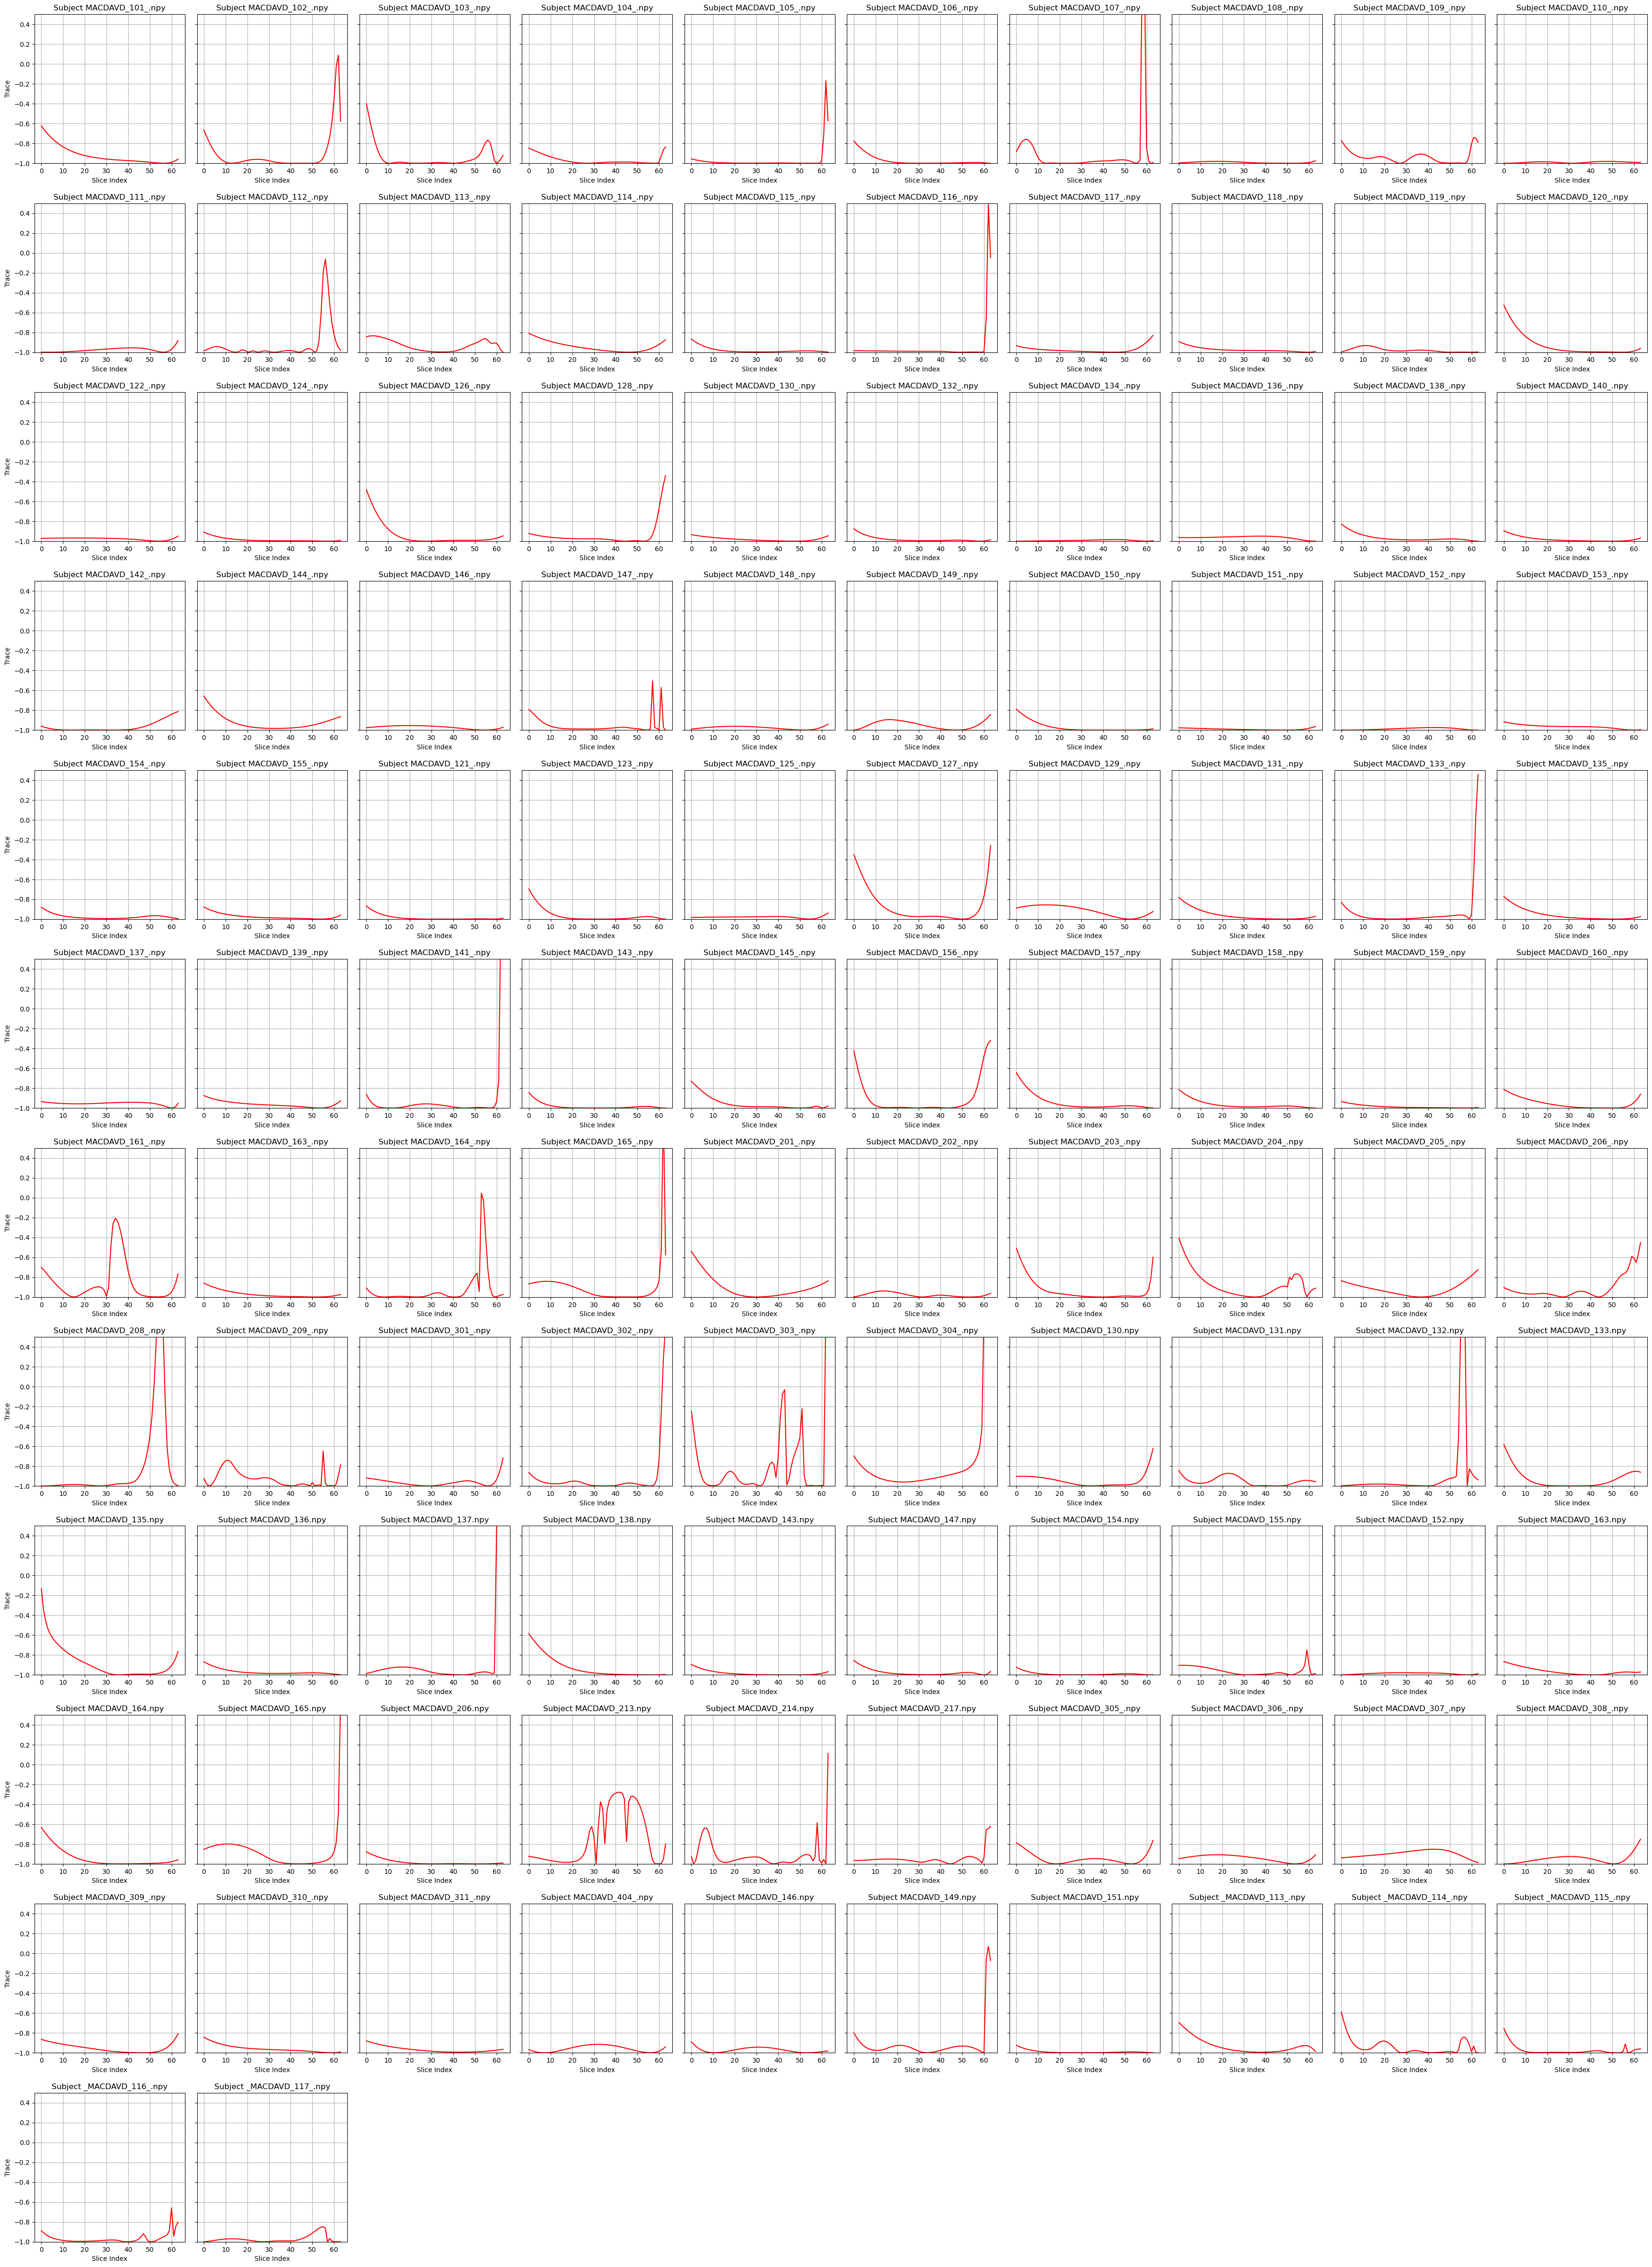

In [6]:
# Parameters for the grid layout
num_subjects = len(subjects_traces)
cols = 10  # Maintain the number of columns
rows = num_subjects // cols + (num_subjects % cols > 0)  # Calculate rows needed

# Increase figure size for better visibility, consider the screen size and resolution
plt.figure(figsize=(35, rows * 4))  # Increase width and height for more space per subplot

for n, (subject_id, traces) in enumerate(subjects_traces.items()):
    ax = plt.subplot(rows, cols, n+1)  # Create a subplot for the current subject
    
    # Plot traces with a shared y-axis
    ax.plot(traces, color='red')
    ax.set_xlabel('Slice Index', fontsize=10)
    if n % cols == 0:  # Only add y-label to the first plot in each row
        ax.set_ylabel('Trace', fontsize=10)
    ax.set_title(f'Subject {subject_id}', fontsize=12)
    ax.set_ylim([-1, 0.5])  # Standardize the Y-axis range for all plots
    ax.grid(True)
    
    # Adjust tick labels visibility and font size
    if n % cols != 0:
        plt.setp(ax.get_yticklabels(), visible=False)
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)

plt.tight_layout(pad=1.0, w_pad=1.5, h_pad=1.5)  # Increase padding to prevent overlap
#plt.savefig('rotation_matrices_traces_high_res.png', dpi=300)  # Save with higher DPI for better resolution
plt.show()


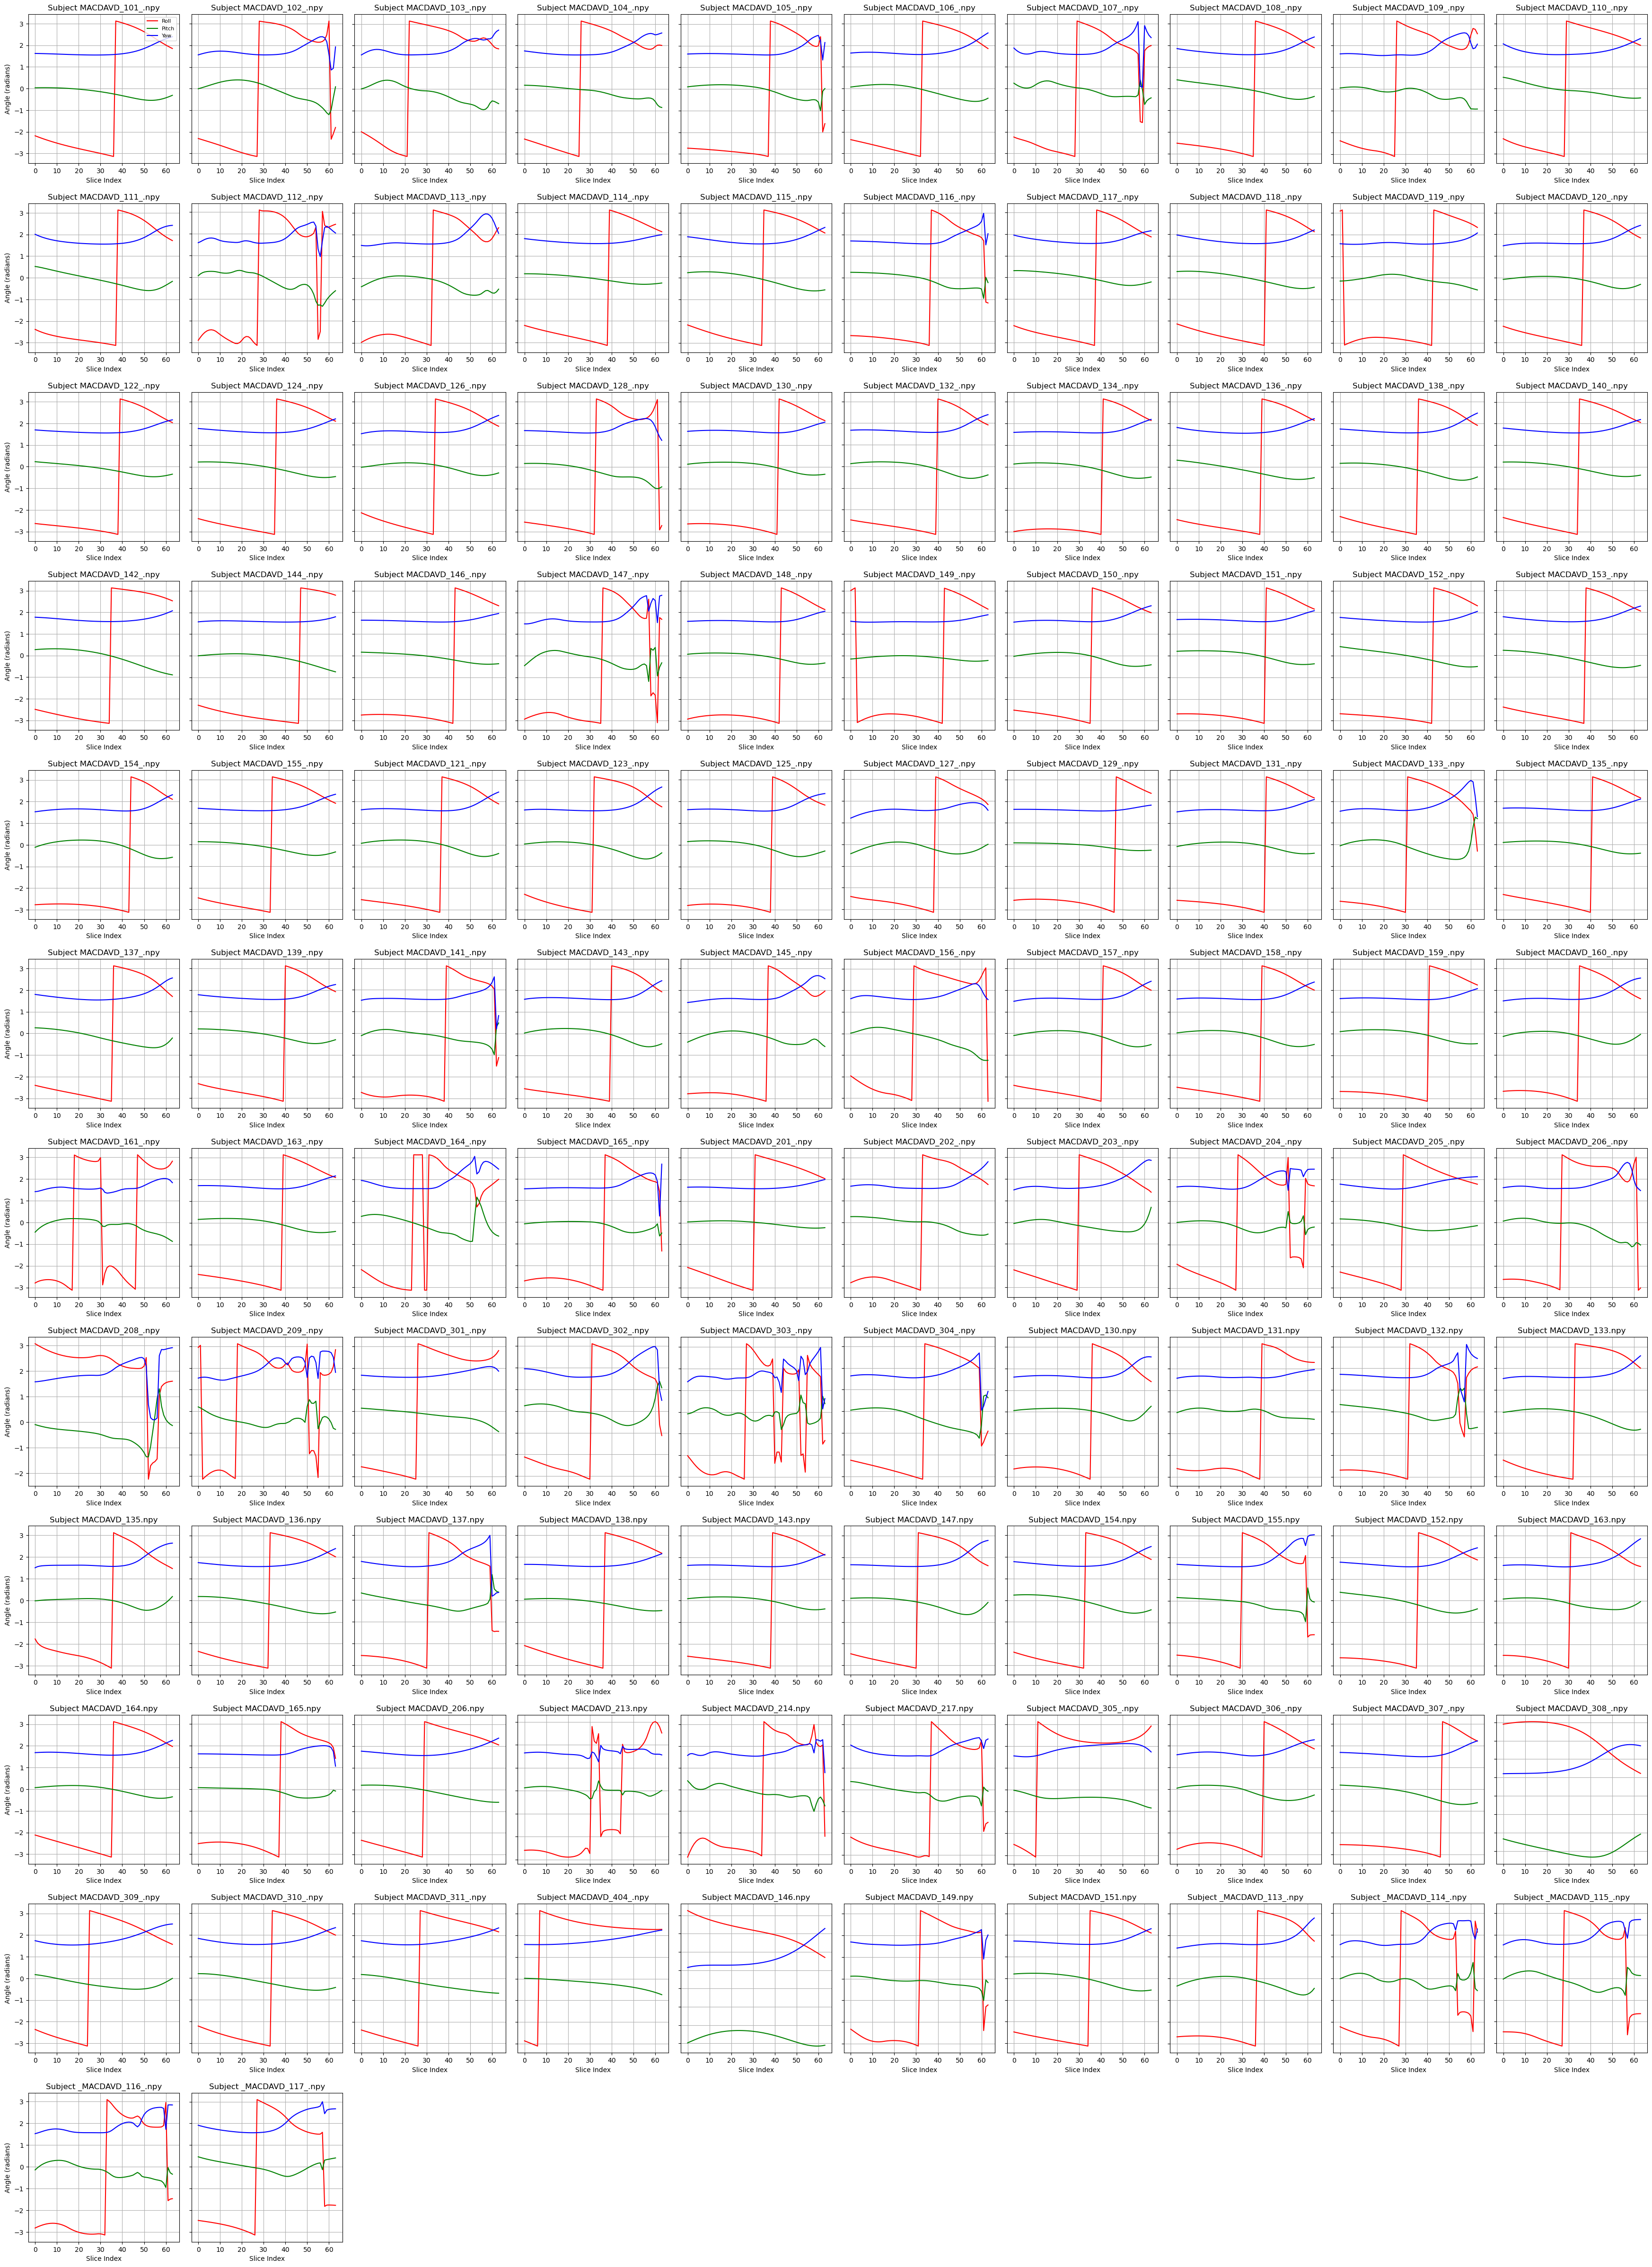

In [7]:
# Parameters for the grid layout
num_subjects = len(subjects_euler_angles)
cols = 10  # Adjust based on your display capabilities
rows = num_subjects // cols + (num_subjects % cols > 0)  # Calculate rows needed

# Increase figure size for better visibility, considering the screen size and resolution
plt.figure(figsize=(35, rows * 4))  # Increase width and height for more space per subplot

for n, (subject_id, angles) in enumerate(subjects_euler_angles.items()):
    ax = plt.subplot(rows, cols, n+1)  # Create a subplot for the current subject
    
    # Ensure angles is a numpy array for easier indexing
    angles = np.array(angles)
    
    # Plot all three Euler angles in the same subplot
    ax.plot(angles[:, 0], label='Roll', color='red')
    ax.plot(angles[:, 1], label='Pitch', color='green')
    ax.plot(angles[:, 2], label='Yaw', color='blue')
    
    ax.set_xlabel('Slice Index', fontsize=10)
    if n % cols == 0:  # Only add y-label to the first plot in each row
        ax.set_ylabel('Angle (radians)', fontsize=10)
    ax.set_title(f'Subject {subject_id}', fontsize=12)
    ax.grid(True)
    
    # Hide y-tick labels for subplots that are not in the first column
    if n % cols != 0:
        plt.setp(ax.get_yticklabels(), visible=False)
    # Adjust the font size of the tick labels to prevent overlap
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    
    # Add a legend if it's the first subplot, or adjust as needed
    if n == 0:
        ax.legend(fontsize=8, loc='upper right')

plt.tight_layout(pad=1.0, w_pad=1.5, h_pad=1.5)  # Increase padding to prevent overlap
#plt.savefig('euler_angles_large.png', dpi=300)  # Save with higher DPI for better resolution
plt.show()
